In [1]:
import importer
import tensorflow as tf
import pickle
import numpy as np
import sys
import utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import saconfig
import time

In [2]:
# import pickle
with open('data.pickle', 'rb') as file_handler:
    data = pickle.load(file_handler)

In [3]:
data

{'filename': array(['1364512096.38213_1.leviathan.boiteameuh.org',
        '1484686097.19650_2.banquise',
        '1364512269.48016_1.leviathan.boiteameuh.org', ...,
        '1472037113.M315432P26537.banquise,S=1211,W=1242',
        '1277219860.M354931P27930.stinger.boiteameuh.org',
        '1388160722.74539_1.leviathan.boiteameuh.org'], 
       dtype='<U69'),
 'hot-ones': array([[ True,  True, False, ..., False, False, False],
        [ True, False,  True, ..., False, False, False],
        [ True,  True, False, ..., False, False, False],
        ..., 
        [ True, False, False, ..., False, False, False],
        [False,  True, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]], dtype=bool),
 'labels': array([False, False, False, ..., False, False, False], dtype=bool),
 'messageid': array(['<20090924113447.9CE7C7900FE@fax-1-b6.proxad.net>',
        '<20170117154804.8625232.1818143@sailthru.com>',
        '<-5776905360315523008@unknownmsgid>',

In [4]:
(data['labels'][:,np.newaxis]).shape

(97215, 1)

In [5]:
class SALearner:
    def __init__(self, data, learning_rate):
        # extract data
        # TODO rename filename to filenames
        self.filenames = data['filename']
        # TODO rename messageid to messageids
        self.messageids = data['messageid']
        # TODO check the names hot-ones
        self.dataset = data['hot-ones'].astype(np.float32)
        # TODO return a real column vector on importer
        self.labels = data['labels'][:,np.newaxis].astype(np.float32)
        # description variables
        self.nb_ind = data['hot-ones'].shape[0]
        self.ind_size = data['hot-ones'].shape[1]
        # Variables learned
        self.tf_weights = None
        self.tf_bias = None
        # Hyperparameters
        self.learning_rate = learning_rate
        # Training stats
        self.cost_data = utils.MAAcumulator(1)
        self.accuracy_data = utils.MAAcumulator(1)
        # Results
        self.__weights = None
        self.__bias = None
        
    def init_graph(self):
        tf.reset_default_graph()
        # data
        tf_data = tf.placeholder(tf.float32, name='data')
        tf_labels = tf.placeholder(tf.float32, name='labels')
        # weights and bias
        self.tf_weights = tf.Variable(tf.truncated_normal([self.ind_size, 1]))
        self.tf_bias = tf.Variable(tf.zeros([1,1]))
        # Compute the unit unit
        tf_z = tf.matmul(tf_data, self.tf_weights) + self.tf_bias #z.shape -> [ind_size,1]
        tf_h = tf.sigmoid(tf_z)
        
        self.tf_regu = tf.reduce_mean(tf.multiply(self.tf_weights, self.tf_weights)) * 1e-7
        self.tf_cost_function = tf.reduce_mean(tf_labels * -tf.log(tf.clip_by_value(tf_h,1e-10, 1)) + \
                                               (1 - tf_labels) * -tf.log(tf.clip_by_value(1 - tf_h, 1e-10, 1))) + \
                                                self.tf_regu
        # accuracy & details
        tf_decision_vector = tf.round(tf_h)
        tf_correct_prediction = tf.equal(tf_labels, tf_decision_vector)
        self.tf_accuracy = tf.reduce_mean(tf.cast(tf_correct_prediction, tf.float32)) * 100
        # True positive
        self.tf_tp = tf.reduce_mean(tf.cast(tf.logical_and(tf.cast(tf_decision_vector, tf.bool),
                                                           tf.cast(tf_labels, tf.bool)), tf.float32)) * 100
        # True negative
        self.tf_tn = tf.reduce_mean(tf.cast(tf.logical_not(tf.logical_or(tf.cast(tf_decision_vector, tf.bool),
                                                           tf.cast(tf_labels, tf.bool))), tf.float32)) * 100
        # false negative
        self.tf_fn = tf.reduce_mean(tf.cast(tf.logical_and(tf.cast(tf_decision_vector, tf.bool),
                                                           tf.logical_not(tf.cast(tf_labels, tf.bool))),
                                            tf.float32)) * 100
        # false positive (baad)
        self.tf_fp = tf.reduce_mean(tf.cast(tf.logical_and(tf.logical_not(tf.cast(tf_decision_vector, tf.bool)),
                                                           tf.cast(tf_labels, tf.bool)),
                                            tf.float32)) * 100
        
        # GD
        self.tf_train_step = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.tf_cost_function)
        
        self.tf_init = tf.global_variables_initializer()
        
    def learn(self, nb_cycle, info_every_cycle, quiet=False):
        sess = tf.Session()
        sess.run(self.tf_init)
        # reset accumulators
        self.cost_data.reset()
        self.accuracy_data.reset()
        # get placeholders
        tf_data = tf.get_default_graph().get_tensor_by_name('data:0')
        tf_labels = tf.get_default_graph().get_tensor_by_name('labels:0')

        
        for cycle in range(nb_cycle):
            _, cost, acc, weights, bias, tp, tn, fp, fn, regu = sess.run([self.tf_train_step, self.tf_cost_function,
                                                                          self.tf_accuracy, self.tf_weights,
                                                                          self.tf_bias,
                                                                          self.tf_tp, self.tf_tn,
                                                                          self.tf_fp, self.tf_fn,self.tf_regu],
                                                                        feed_dict={tf_data: self.dataset,
                                                                                   tf_labels: self.labels})
            # data accumulation
            self.cost_data.add(cost)
            self.accuracy_data.add(acc)
            # results
            self.__weights = weights
            self.__bias = bias
            # Console printing
            if (cycle+1) % info_every_cycle == 0 and not quiet:
                print('-' * 10)
                print('cycle: {}'.format(cycle))
                print('cost: {}'.format(cost))
                print('regu: {}'.format(regu))
                print('accuracy: {}%'.format(acc))
                print('true positive: {}%'.format(tp))
                print('true negative: {}%'.format(tn))
                print('false positive: {}%'.format(fp))
                print('false negative: {}%'.format(fn))
                sys.stdout.flush()
        
    @property
    def results(self):
        return {'weights': self.__weights,
                'bias': self.__bias}

In [6]:
sa_learner = SALearner(data, 30)

In [7]:
begin = time.time()
sa_learner.init_graph()
sa_learner.learn(24800,20,True)
print("{:.2f} seconds".format(time.time() - begin))

26541.90 seconds


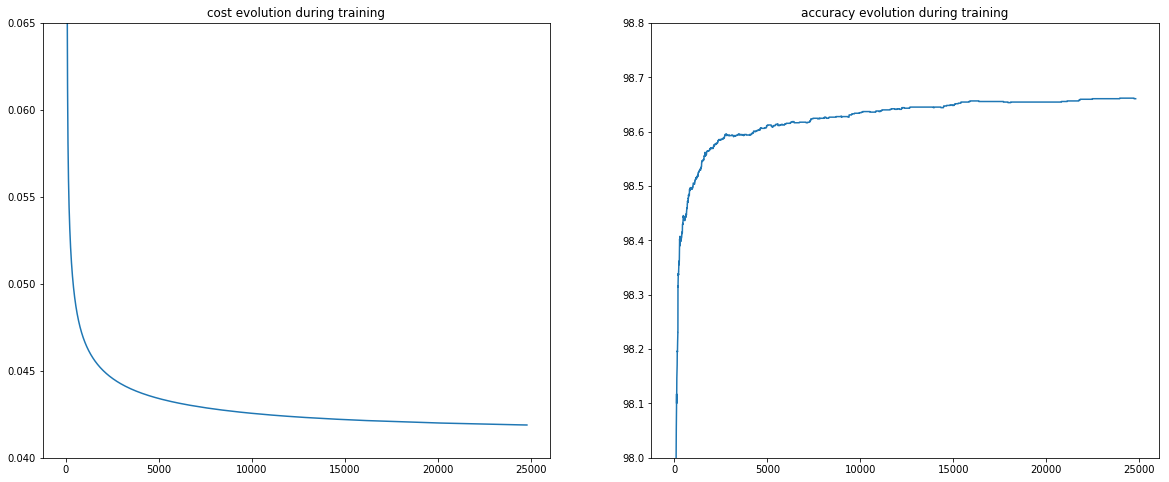

In [19]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = (20.0, 8.0)
f, axarr = plt.subplots(1,2)
# cost
axarr[0].plot(sa_learner.cost_data.data)
axarr[0].set_title('cost evolution during training')
axarr[0].set_ylim(0.040,0.065)
# accuracy
axarr[1].plot(sa_learner.accuracy_data.data)
axarr[1].set_title('accuracy evolution during training')
axarr[1].set_ylim(98.0,98.8)
plt.show()

In [9]:
res = sa_learner.results

In [10]:
cg = saconfig.ConfigGenerator(data['rules'], res['weights'], res['bias'][0,0])

In [11]:
conf = cg.get_config()

In [12]:
with open('/tmp/sa-score.conf', 'w')as a:
    a.write(conf)

In [13]:
print(conf)

required_score 2.36

score AWL -1.44
score BAYES_00 -8.34
score DCC_CHECK 0.94
score HTML_FONT_FACE_BAD -0.51
score HTML_FONT_LOW_CONTRAST -0.33
score HTML_IMAGE_RATIO_04 0.92
score HTML_MESSAGE 0.15
score MIME_HTML_ONLY 1.85
score MIME_HTML_ONLY_MULTI -2.70
score MPART_ALT_DIFF 1.56
score RCVD_IN_DNSWL_NONE -0.08
score URIBL_GREY -0.60
score T_RP_MATCHES_RCVD -0.89
score FREEMAIL_FORGED_REPLYTO 1.04
score HEADER_FROM_DIFFERENT_DOMAINS 0.44
score HTML_IMAGE_ONLY_12 1.79
score HTML_SHORT_LINK_IMG_1 -3.84
score RCVD_IN_DNSWL_LOW -2.40
score RCVD_IN_MSPIKE_H3 0.19
score RCVD_IN_MSPIKE_WL -0.21
score FREEMAIL_FORGED_FROMDOMAIN -2.35
score FREEMAIL_FROM -1.45
score MANGLED_SEX -1.05
score MIME_HTML_MOSTLY 0.95
score NIX_SPAM 1.65
score T_KAM_HTML_FONT_INVALID -2.62
score LOTS_OF_MONEY -1.05
score US_DOLLARS_3 0.80
score DKIM_SIGNED 2.41
score DKIM_VALID -2.02
score DKIM_VALID_AU 1.24
score RCVD_IN_MSPIKE_H2 0.06
score SPF_PASS -0.60
score MIME_BAD_LINEBREAK -0.09
score MIME_QP_LONG_LINE 0.1